# Memory Impact from Checkpointing

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import DataLoader
from torch_scatter import scatter_add

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric

from torch.utils.checkpoint import checkpoint

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import *
from performance_utils import *
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [43]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Load Scrubbed Filter-ready Events

In [2]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
basename = os.path.join(load_dir, str(pt_cut) + "_pt_cut")
train_path = os.path.join(basename, str(train_number) + "_events_train.pkl")
test_path = os.path.join(basename, str(test_number) + "_events_test.pkl")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset[:], batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset[:], batch_size=1, shuffle=True)

CPU times: user 171 ms, sys: 11.6 s, total: 11.8 s
Wall time: 15.3 s


## GNN Memory Tests

In [4]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, inputs):
        # Select the features of the associated nodes
        start, end = inputs[1]
        edge_inputs = torch.cat([inputs[0][start], inputs[0][end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, inputs):
        start, end = inputs[2]
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(inputs[1][:, None] * inputs[0][start], end, dim=0, dim_size=inputs[0].shape[0])
        mo = scatter_add(inputs[1][:, None] * inputs[0][end], start, dim=0, dim_size=inputs[0].shape[0])
        node_inputs = torch.cat([mi, mo, inputs[0]], dim=1)
        return self.network(node_inputs)

class ResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(ResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        input_x = x
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, input_x], dim=-1)
#         print(x.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network((x, edge_index)))
        
            # Apply node network
            x = self.node_network((x, e, edge_index))
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, input_x], dim=-1)  
            
            x = x_inital + x
        
        return self.edge_network((x, edge_index))


class CheckResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(CheckResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        self.dummy_tensor = torch.ones(1, dtype=torch.float32, requires_grad=True)
        
    def custom_forward(self, inputs):
        # Apply edge network
        print("x in check (before)", inputs[0], inputs[0].requires_grad)
        e = self.edge_network((inputs[0], inputs[1]))
        e = torch.sigmoid(e)
        x = self.node_network((inputs[0], e, inputs[1]))
        print("e in check", e, e.requires_grad)
        print("x in check (after)", x, x.requires_grad)
        # Apply node network
        return x
    
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        input_x = x
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, input_x], dim=-1)
#         print(x.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            
            x_inital = x
            print("x before check", x, x.requires_grad)
            x = checkpoint(self.custom_forward, (x, edge_index, self.dummy_tensor))
#             x = self.custom_forward((x, edge_index))
            print("x after check", x, x.requires_grad)
#             x.requires_grad_(True)
            # Apply edge network
#             e = checkpoint(self.edge_network, (x, edge_index))
#             e = self.edge_network((x, edge_index))
#             e = torch.sigmoid(e)
        
            # Apply node network
#             x = checkpoint(self.node_network, (x, e, edge_index))
#             x = self.node_network((x, e, edge_index))
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, input_x], dim=-1)  
            
            x = x_inital + x
            
        e = self.edge_network((x, edge_index))
#         e = torch.sigmoid(e)
        
        return e
    
class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, x, edge_index):

        # Encode the graph features into the hidden space
        x = self.node_encoder(x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, edge_index[1], dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)
    
class CheckMPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(CheckMPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, x, edge_index):

        # Encode the graph features into the hidden space
        x = self.node_encoder(x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
            e = checkpoint(self.edge_network, edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, edge_index[1], dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = checkpoint(self.node_network, node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return checkpoint(self.edge_classifier, clf_inputs).squeeze(-1)

In [5]:
class Filter(torch.nn.Module):
    def __init__(self, in_channels, emb_channels, hidden, nb_layer):
        super(Filter, self).__init__()
        self.input_layer = Linear(in_channels*2 + emb_channels*2, hidden)
        layers = [Linear(hidden, hidden) for _ in range(nb_layer-1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(hidden, 1)
        self.norm = nn.LayerNorm(hidden)
        self.act = nn.Tanh()

    def forward(self, x, e, emb=None):
        if emb is not None:
            x = self.input_layer(torch.cat([x[e[0]], emb[e[0]], x[e[1]], emb[e[1]]], dim=-1))
        else:
            x = self.input_layer(torch.cat([x[e[0]], x[e[1]]], dim=-1))
        for l in self.layers:
            x = l(x)
            x = self.act(x)
#         x = self.norm(x) #Option of LayerNorm
        x = self.output_layer(x)
        return x

In [5]:
def train_gnn(model, train_loader, optimizer, m_configs):
    
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        if m_configs['ratio'] != 0:
            num_true = batch.y.sum()
            fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
            true_indices = np.where(batch.y.bool())[0]
            combined_indices = np.concatenate([true_indices, fake_indices])

            x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
            weight = torch.tensor(m_configs['ratio'])
            combined_y = batch.y[combined_indices]   
        
        else:
            x, e = batch.x.to(device), batch.e_radius.to(device)
            weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
            combined_y = batch.y         
        
        output = model(x, e).squeeze()
        
        y_pid = (batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]).float()
                
#         loss = F.binary_cross_entropy_with_logits(output.cpu(), combined_y, pos_weight = weight)
        loss = F.binary_cross_entropy_with_logits(output.cpu(), y_pid, pos_weight = torch.tensor(3))
        total_loss += loss.item()
#         print(i, loss)
        loss.backward()
        optimizer.step()
    
    return total_loss

def evaluate_gnn(model, test_loader, m_configs):
    
    edge_true, edge_true_positive, edge_positive, edge_total_positive, edge_total_true, edge_total_true_positive = [0]*6
    total_loss = 0
    
    for i, batch in enumerate(test_loader):
            
#         subset_ind = np.random.choice(np.arange(0, batch.e_radius.shape[1]), int(m_configs['test_subset']*batch.e_radius.shape[1]), replace=False)
        if m_configs['ratio'] != 0:
            subset_ind = np.random.randint(0, batch.e_radius.shape[1], 10000)
        else:
            subset_ind = np.arange(0, batch.e_radius.shape[1])
        x, e = batch.x.to(device), batch.e_radius[:, subset_ind].to(device)
        output = model(x, e).squeeze()
        
        y_pid = (batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]).float()
        
#         loss = F.binary_cross_entropy_with_logits(output.cpu(), batch.y[subset_ind])
        loss = F.binary_cross_entropy_with_logits(output.cpu(), y_pid)
        total_loss += loss.item()
        
        preds = F.sigmoid(output.cpu()) > 0.5
        
        #Edge filter performance
#         edge_true = batch.y[subset_ind].sum()
        edge_true = y_pid.sum()
#         edge_true_positive = (batch.y[subset_ind].bool() & preds).sum()
        edge_true_positive = (y_pid.bool() & preds).sum()
        edge_positive = preds.sum()
        
        edge_total_true_positive += edge_true_positive
        edge_total_positive += edge_positive
        edge_total_true += edge_true
        
#         print("True positive:", edge_true_positive, "True:", edge_true, "Positive:", edge_positive)

    edge_eff = edge_total_true_positive.float() / max(edge_total_true.float(), 1)
    edge_pur = edge_total_true_positive.float() / max(edge_total_positive.float(), 1)

    return edge_pur, edge_eff, total_loss


### Benchmark Tests

In [6]:
torch.manual_seed(0)

# m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 6}
# model = ResAGNN(**m_configs).to(device)

m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 8, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

other_configs = {'ratio': 0, 'test_subset': 0.001}
m_configs.update(other_configs)
model_name = wandb.init(project="CheckpointExploration", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

torch.cuda.reset_max_memory_allocated()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
model.train()

total_loss = 0
tic = tt()
for i, batch in enumerate(train_loader):
    optimizer.zero_grad()

    if m_configs['ratio'] != 0:
        num_true = batch.y.sum()
        fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
        true_indices = np.where(batch.y.bool())[0]
        combined_indices = np.concatenate([true_indices, fake_indices])

        x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
        weight = torch.tensor(m_configs['ratio'])
        combined_y = batch.y[combined_indices]   

    else:
        x, e = batch.x.to(device), batch.e_radius.to(device)
        weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
        combined_y = batch.y         
    x.requires_grad_(True)
    
    output = model(x, e)

    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    total_loss += loss.item()
#         print(i, loss)
    loss.backward()
    optimizer.step()
    
    break
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3, "- time:", tt()-tic)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Memory max (GB): 9.888021469116211 - time: 1.5440750122070312


In [61]:
output_not_checkpointed = output.data.clone()
grad_not_checkpointed = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_not_checkpointed[name] = param.grad.data.clone()
    else:
        print(name, "is NONE!")

In [65]:
output_not_checkpointed

tensor([0.6636, 0.6636, 0.6636,  ..., 0.9206, 1.1540, 1.1405], device='cuda:0')

In [66]:
output_checkpointed

tensor([0.6636, 0.6636, 0.6636,  ..., 0.9206, 1.1540, 1.1405], device='cuda:0')

In [ ]:
grad_not_checkpointed

In [ ]:
grad_checkpointed

In [90]:
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3)

Memory max (GB): 1.2986721992492676


### Checkpointed Tests

In [12]:
torch.manual_seed(0)

# m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 6}
# model = CheckResAGNN(**m_configs).to(device)

m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 8, "layer_norm": True}
model = CheckMPNN_Network(**m_configs).to(device)

other_configs = {'ratio': 0, 'test_subset': 0.001}
m_configs.update(other_configs)
model_name = wandb.init(project="CheckpointExploration", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

torch.cuda.reset_max_memory_allocated()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
model.train()

total_loss = 0
tic = tt()
for i, batch in enumerate(train_loader):
    optimizer.zero_grad()

    if m_configs['ratio'] != 0:
        num_true = batch.y.sum()
        fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
        true_indices = np.where(batch.y.bool())[0]
        combined_indices = np.concatenate([true_indices, fake_indices])

        x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
        weight = torch.tensor(m_configs['ratio'])
        combined_y = batch.y[combined_indices]   

    else:
        x, e = batch.x.to(device), batch.e_radius.to(device)
        weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
        combined_y = batch.y         
#     x.requires_grad_(True)
    output = model(x, e)
    
    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    total_loss += loss.item()
#         print(i, loss)
    loss.backward()
    
#     output.mean().backward()
    optimizer.step()
    
    break
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3, "- time:", tt()-tic)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Memory max (GB): 6.213899612426758 - time: 1.9646477699279785


In [64]:
output_checkpointed = output.data.clone()
grad_checkpointed = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_checkpointed[name] = param.grad.data.clone()
    else:
        print(name, "is NONE!")

### Memory Grid Scan

Want to scan over MP iterations, network size (width), and MLP layers.

In [17]:
layer_set = 1, 7, 1
iteration_set = 1, 9, 1
channel_set = 8, 128, 8

In [18]:
def train_step(input_data, model, optimizer):
    optimizer.zero_grad()

    x, e = input_data.x.to(device), input_data.e_radius.to(device)
    weight = torch.tensor((~input_data.y.bool()).sum() / input_data.y.sum())
    combined_y = input_data.y         
    x.requires_grad_(True)

    output = model(x, e)

    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    loss.backward()
    optimizer.step()

In [19]:
input_data = train_dataset[0]

In [ ]:
%%time
memory_uncheck = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
memory_check = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
time_uncheck = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
time_check = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))


for i, layers in enumerate(np.arange(*layer_set)):
    for j, iterations in enumerate(np.arange(*iteration_set)):
        for k, channels in enumerate(np.arange(*channel_set)):
            
            torch.cuda.reset_max_memory_allocated()
            torch.manual_seed(0)

            m_configs = {"input_dim": 3, "hidden_node_dim": channels, "hidden_edge_dim": channels, "in_layers": layers, "node_layers": layers, "edge_layers": layers, "n_graph_iters": iterations, "layer_norm": True}
            model = MPNN_Network(**m_configs).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
            
            tic = tt()
            train_step(input_data, model, optimizer)
            tic_uncheck = tt() - tic
            time_uncheck[i, j, k] = tic_uncheck
            max_mem_uncheck = torch.cuda.max_memory_allocated() / 1024**3
            memory_uncheck[i, j, k] = max_mem_uncheck
            
                        
            torch.cuda.reset_max_memory_allocated()
            torch.manual_seed(0)
            
            model = CheckMPNN_Network(**m_configs).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
            
            tic = tt()
            train_step(input_data, model, optimizer)
            tic_check = tt() - tic
            time_check[i, j, k] = tic_check
            max_mem_check = torch.cuda.max_memory_allocated() / 1024**3
            memory_check[i, j, k] = max_mem_check
            print("Step:", (i, j, k), "- Memory (unchecked):", max_mem_uncheck, "(checked):", max_mem_check)

#### Compare Checked and Unchecked

In [52]:
mem_ratio = memory_uncheck / memory_check
time_ratio = time_check / time_uncheck

In [53]:
layer_list = np.arange(*layer_set)
iteration_list = np.arange(*iteration_set)
channel_list = np.arange(*channel_set)

In [161]:
mean_mem_ratio = np.mean(mem_ratio, axis=2)
max_mem_ratio = np.max(mem_ratio, axis=2)
mean_time_ratio = np.mean(time_ratio, axis=2)
max_time_ratio = np.max(time_ratio, axis=2)

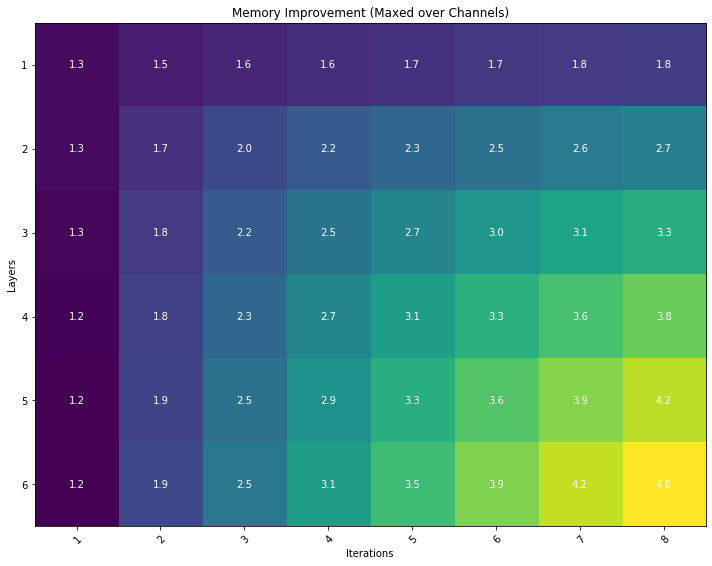

In [158]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(max_mem_ratio)

ax.set_xticklabels(np.arange(0, 9))
ax.set_yticklabels(np.arange(0, 8))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(layer_list)):
    for j in range(len(iteration_list)):
        text = ax.text(j, i, str('{:.1f}').format(max_mem_ratio[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Memory Improvement (Maxed over Channels)")
plt.xlabel("Iterations")
plt.ylabel("Layers")
fig.tight_layout()
plt.show()

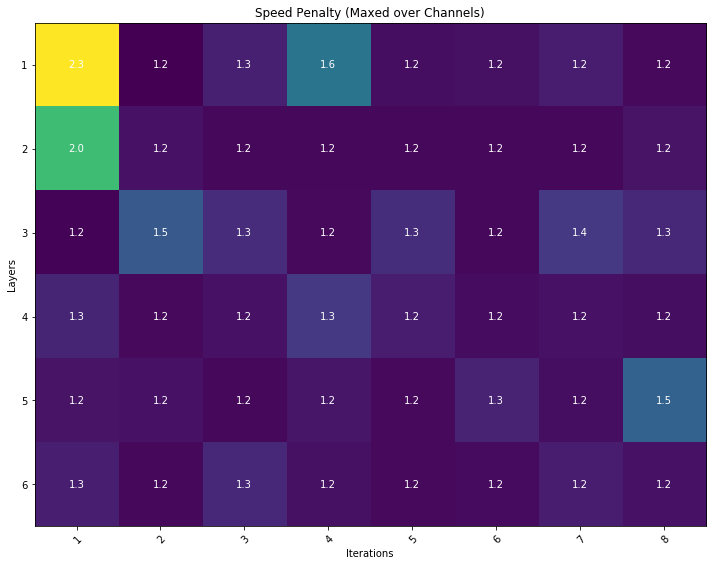

In [159]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(max_time_ratio)

ax.set_xticklabels(np.arange(0, 9))
ax.set_yticklabels(np.arange(0, 8))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(layer_list)):
    for j in range(len(iteration_list)):
        text = ax.text(j, i, str('{:.1f}').format(max_time_ratio[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Speed Penalty (Maxed over Channels)")
plt.xlabel("Iterations")
plt.ylabel("Layers")
fig.tight_layout()
plt.show()

### Regular Training

In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_gnn(model, train_loader, optimizer, m_configs)
    print('Training loss: {:.4f} in time {}'.format(train_loss, tt() - tic))

    model.eval()
    with torch.no_grad():
        edge_pur, edge_eff, val_loss = evaluate_gnn(model, test_loader, m_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_pur": edge_pur, "edge_eff": edge_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_eff, edge_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))